In [2]:
import scipy.io as sio
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
import time
import torch
from torch import nn
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
import time


from tqdm import tqdm

from models.apl import *
# from models.apl_plus import *

In [3]:
batch_size = 128
num_epochs = 200

# load data

In [5]:
data_amp = sio.loadmat('data/train_data_split_amp.mat')
train_data_amp = data_amp['train_data']
train_data = train_data_amp
# data_pha = sio.loadmat('data/train_data_split_pha.mat')
# train_data_pha = data_pha['train_data']
# train_data = np.concatenate((train_data_amp,train_data_pha),1)

train_activity_label = data_amp['train_activity_label']
train_location_label = data_amp['train_location_label']
train_label = np.concatenate((train_activity_label, train_location_label), 1)

num_train_instances = len(train_data)

train_data = torch.from_numpy(train_data).type(torch.FloatTensor)
train_label = torch.from_numpy(train_label).type(torch.LongTensor)
# train_data = train_data.view(num_train_instances, 1, -1)
# train_label = train_label.view(num_train_instances, 2)

train_dataset = TensorDataset(train_data, train_label)
train_data_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

In [6]:
data_amp = sio.loadmat('data/test_data_split_amp.mat')
test_data_amp = data_amp['test_data']
test_data = test_data_amp
# data_pha = sio.loadmat('data/test_data_split_pha.mat')
# test_data_pha = data_pha['test_data']
# test_data = np.concatenate((test_data_amp,test_data_pha), 1)

test_activity_label = data_amp['test_activity_label']
test_location_label = data_amp['test_location_label']
test_label = np.concatenate((test_activity_label, test_location_label), 1)

num_test_instances = len(test_data)

test_data = torch.from_numpy(test_data).type(torch.FloatTensor)
test_label = torch.from_numpy(test_label).type(torch.LongTensor)
# test_data = test_data.view(num_test_instances, 1, -1)
# test_label = test_label.view(num_test_instances, 2)

test_dataset = TensorDataset(test_data, test_label)
test_data_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
aplnet = ResNet(block=BasicBlock, layers=[1, 1, 1, 1], inchannel=52)
# aplnet = ResNet(block=BasicBlock, layers=[2, 2, 2, 2], inchannel=52)
# aplnet = ResNet(block=BasicBlock, layers=[3, 4, 6, 3], inchannel=52)
#

# aplnet = ResNet(block=Bottleneck, layers=[2, 3, 4, 6])

aplnet = aplnet.cuda()

criterion = nn.CrossEntropyLoss(size_average=False).cuda()

optimizer = torch.optim.Adam(aplnet.parameters(), lr=0.005)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                 milestones=[10, 20, 30, 40, 60, 70, 80, 90, 100, 110, 120, 130,
                                                             140, 150, 160, 170, 180, 190, 200, 250, 300],
                                                 gamma=0.5)

/home/user2/miniconda3/envs/torch_cuda111/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [8]:
train_loss_act = np.zeros([num_epochs, 1])
train_loss_loc = np.zeros([num_epochs, 1])
test_loss_act = np.zeros([num_epochs, 1])
test_loss_loc = np.zeros([num_epochs, 1])
train_acc_act = np.zeros([num_epochs, 1])
train_acc_loc = np.zeros([num_epochs, 1])
test_acc_act = np.zeros([num_epochs, 1])
test_acc_loc = np.zeros([num_epochs, 1])

In [9]:
for epoch in range(num_epochs):
    print('Epoch:', epoch)
    aplnet.train()
    scheduler.step()
    # for i, (samples, labels) in enumerate(train_data_loader):
    loss_x = 0
    loss_y = 0
    for (samples, labels) in tqdm(train_data_loader):
        samplesV = Variable(samples.cuda())
        labels_act = labels[:, 0].squeeze()
        labels_loc = labels[:, 1].squeeze()
        labelsV_act = Variable(labels_act.cuda())
        labelsV_loc = Variable(labels_loc.cuda())

        # Forward + Backward + Optimize
        optimizer.zero_grad()
        predict_label_act, predict_label_loc,_,_,_,_,_,_,_ = aplnet(samplesV)

        loss_act = criterion(predict_label_act, labelsV_act)
        loss_loc = criterion(predict_label_loc, labelsV_loc)

        loss = loss_act + loss_loc
        # loss = loss_loc
        # print(loss.item())
        loss.backward()
        optimizer.step()

        # loss = loss1+0.5*loss2+0.25*loss3+0.25*loss4
        # loss = loss1+loss2+loss3+loss4

        loss_x += loss_act.item()
        loss_y += loss_loc.item()

        # loss.backward()
        # optimizer.step()

    train_loss_act[epoch] = loss_x / num_train_instances
    train_loss_loc[epoch] = loss_y / num_train_instances

    aplnet.eval()
    # loss_x = 0
    correct_train_act = 0
    correct_train_loc = 0
    for i, (samples, labels) in enumerate(train_data_loader):
        with torch.no_grad():
            samplesV = Variable(samples.cuda())
            labels = labels.squeeze()

            labels_act = labels[:, 0].squeeze()
            labels_loc = labels[:, 1].squeeze()
            labelsV_act = Variable(labels_act.cuda())
            labelsV_loc = Variable(labels_loc.cuda())

            predict_label_act, predict_label_loc,_,_,_,_,_,_,_ = aplnet(samplesV)

            prediction = predict_label_loc.data.max(1)[1]
            correct_train_loc += prediction.eq(labelsV_loc.data.long()).sum()

            prediction = predict_label_act.data.max(1)[1]
            correct_train_act += prediction.eq(labelsV_act.data.long()).sum()

            loss_act = criterion(predict_label_act, labelsV_act)
            loss_loc = criterion(predict_label_loc, labelsV_loc)
            # loss_x += loss.item()

    print("Activity Training accuracy:", (100 * float(correct_train_act) / num_train_instances))
    print("Location Training accuracy:", (100 * float(correct_train_loc) / num_train_instances))
    print("Activity Training loss:", loss_x / num_train_instances )
    print("Location Training loss:", loss_y / num_train_instances)

    # train_loss[epoch] = loss_x / num_train_instances
    train_acc_act[epoch] = 100 * float(correct_train_act) / num_train_instances
    train_acc_loc[epoch] = 100 * float(correct_train_loc) / num_train_instances


    trainacc_act = str(100 * float(correct_train_act) / num_train_instances)[0:6]
    trainacc_loc = str(100 * float(correct_train_loc) / num_train_instances)[0:6]
    

    loss_x = 0
    loss_y = 0
    correct_test_act = 0
    correct_test_loc = 0
    for i, (samples, labels) in enumerate(test_data_loader):
        with torch.no_grad():
            samplesV = Variable(samples.cuda())
            labels_act = labels[:, 0].squeeze()
            labels_loc = labels[:, 1].squeeze()
            labelsV_act = Variable(labels_act.cuda())
            labelsV_loc = Variable(labels_loc.cuda())

        predict_label_act, predict_label_loc,_,_,_,_,_,_,_ = aplnet(samplesV)
        prediction = predict_label_act.data.max(1)[1]
        correct_test_act += prediction.eq(labelsV_act.data.long()).sum()

        prediction = predict_label_loc.data.max(1)[1]
        correct_test_loc += prediction.eq(labelsV_loc.data.long()).sum()

        loss_act = criterion(predict_label_act, labelsV_act)
        loss_loc = criterion(predict_label_loc, labelsV_loc)
        loss_x += loss_act.item()
        loss_y += loss_loc.item()

    print("Activity Test accuracy:", (100 * float(correct_test_act) / num_test_instances))
    print("Location Test accuracy:", (100 * float(correct_test_loc) / num_test_instances))
    print("Activity Test loss:", loss_x / num_test_instances )
    print("Location Test loss:", loss_y / num_test_instances)

    test_loss_act[epoch] = loss_x / num_test_instances
    test_acc_act[epoch] = 100 * float(correct_test_act) / num_test_instances

    test_loss_loc[epoch] = loss_y / num_test_instances
    test_acc_loc[epoch] = 100 * float(correct_test_loc) / num_test_instances

    testacc_act = str(100 * float(correct_test_act) / num_test_instances)[0:6]
    testacc_loc = str(100 * float(correct_test_loc) / num_test_instances)[0:6]

    if epoch == 0:
        temp_test = correct_test_act
        temp_train = correct_train_act
    elif correct_test_act > temp_test:
        torch.save(aplnet, 'weights/net1111epoch' + str(
            epoch) + 'Train' + trainacc_act + 'Test' + testacc_act + 'Train' + trainacc_loc + 'Test' + testacc_loc + '.pkl')

        temp_test = correct_test_act
        temp_train = correct_train_act


# for learning curves
sio.savemat(
    'result/net1111TrainLossAct_Train' + str(100 * float(temp_train) / num_train_instances)[
                                                                 0:6] + 'Test' + str(
        100 * float(temp_test) / num_test_instances)[0:6] + '.mat', {'train_loss': train_loss_act})
sio.savemat(
    'result/net1111TestLossACT_Train' + str(100 * float(temp_train) / num_train_instances)[
                                                                0:6] + 'Test' + str(
        100 * float(temp_test) / num_test_instances)[0:6] + '.mat', {'test_loss': test_loss_act})
sio.savemat(
    'result/net1111TrainLossLOC_Train' + str(100 * float(temp_train) / num_train_instances)[
                                 0:6] + 'Test' + str(
        100 * float(temp_test) / num_test_instances)[0:6] + '.mat', {'train_loss': train_loss_loc})
sio.savemat(
    'result/net1111TestLossLOC_Train' + str(100 * float(temp_train) / num_train_instances)[
                                 0:6] + 'Test' + str(
        100 * float(temp_test) / num_test_instances)[0:6] + '.mat', {'test_loss': test_loss_loc})

sio.savemat('result/net1111TrainAccuracyACT_Train' + str(
    100 * float(temp_train) / num_train_instances)[0:6] + 'Test' + str(100 * float(temp_test) / num_test_instances)[
                                                                   0:6] + '.mat', {'train_acc': train_acc_act})
sio.savemat('result/net1111TestAccuracyACT_Train' + str(
    100 * float(temp_train) / num_train_instances)[0:6] + 'Test' + str(100 * float(temp_test) / num_test_instances)[
                                                                   0:6] + '.mat', {'test_acc': test_acc_act})
print(str(100 * float(temp_test) / num_test_instances)[0:6])

sio.savemat('result/net1111TrainAccuracyLOC_Train' + str(
    100 * float(temp_train) / num_train_instances)[0:6] + 'Test' + str(100 * float(temp_test) / num_test_instances)[
                                                                   0:6] + '.mat', {'train_acc': train_acc_loc})
sio.savemat('result/net1111TestAccuracyLOC_Train' + str(
    100 * float(temp_train) / num_train_instances)[0:6] + 'Test' + str(100 * float(temp_test) / num_test_instances)[
                                                                   0:6] + '.mat', {'test_acc': test_acc_loc})

/home/user2/miniconda3/envs/torch_cuda111/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch: 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  6.89it/s]


Activity Training accuracy: 15.14336917562724
Location Training accuracy: 11.469534050179211
Activity Training loss: 2.126258590315405
Location Training loss: 2.085430610137174
Activity Test accuracy: 14.748201438848922
Location Test accuracy: 9.352517985611511
Activity Test loss: 1.9301319396753105
Location Test loss: 4.452474443174952
Epoch: 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 48.02it/s]


Activity Training accuracy: 17.025089605734767
Location Training accuracy: 8.512544802867383
Activity Training loss: 1.8270119150906907
Location Training loss: 1.2139756876080694
Activity Test accuracy: 16.906474820143885
Location Test accuracy: 8.992805755395683
Activity Test loss: 1.9639230837924875
Location Test loss: 9.714547740469733
Epoch: 2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.59it/s]


Activity Training accuracy: 17.293906810035843
Location Training accuracy: 6.630824372759856
Activity Training loss: 1.779933573951858
Location Training loss: 1.0890124262874699
Activity Test accuracy: 16.18705035971223
Location Test accuracy: 6.115107913669065
Activity Test loss: 1.8132561882622809
Location Test loss: 8.98383951530182
Epoch: 3


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 48.28it/s]


Activity Training accuracy: 24.10394265232975
Location Training accuracy: 33.422939068100355
Activity Training loss: 1.7305952639562683
Location Training loss: 0.935992900615952
Activity Test accuracy: 21.58273381294964
Location Test accuracy: 28.776978417266186
Activity Test loss: 1.7880920163161462
Location Test loss: 2.736782650295779
Epoch: 4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 47.88it/s]


Activity Training accuracy: 23.835125448028673
Location Training accuracy: 32.795698924731184
Activity Training loss: 1.6331204786950115
Location Training loss: 0.7948183381002009
Activity Test accuracy: 21.58273381294964
Location Test accuracy: 28.057553956834532
Activity Test loss: 1.766994805644742
Location Test loss: 1.8490257949280224
Epoch: 5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 47.66it/s]


Activity Training accuracy: 30.28673835125448
Location Training accuracy: 41.12903225806452
Activity Training loss: 1.5866521883181774
Location Training loss: 0.7209861919444095
Activity Test accuracy: 26.97841726618705
Location Test accuracy: 41.007194244604314
Activity Test loss: 1.8463424023964423
Location Test loss: 2.538946261508859
Epoch: 6


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.35it/s]


Activity Training accuracy: 21.863799283154123
Location Training accuracy: 34.76702508960574
Activity Training loss: 1.5237883427664372
Location Training loss: 0.7818455439741894
Activity Test accuracy: 21.58273381294964
Location Test accuracy: 33.81294964028777
Activity Test loss: 2.993554094712511
Location Test loss: 4.810942505761016
Epoch: 7


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 47.95it/s]


Activity Training accuracy: 29.480286738351253
Location Training accuracy: 22.043010752688172
Activity Training loss: 1.397336173655739
Location Training loss: 0.6275329384752499
Activity Test accuracy: 29.136690647482013
Location Test accuracy: 21.223021582733814
Activity Test loss: 1.8899518843177412
Location Test loss: 7.77949243998356
Epoch: 8


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 48.96it/s]


Activity Training accuracy: 31.72043010752688
Location Training accuracy: 47.939068100358426
Activity Training loss: 1.3359981591556234
Location Training loss: 0.5935462042422277
Activity Test accuracy: 34.172661870503596
Location Test accuracy: 47.12230215827338
Activity Test loss: 1.835857418801287
Location Test loss: 2.4303993526980174
Epoch: 9


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.78it/s]


Activity Training accuracy: 41.666666666666664
Location Training accuracy: 63.35125448028674
Activity Training loss: 1.25301756226461
Location Training loss: 0.40801468203144686
Activity Test accuracy: 38.489208633093526
Location Test accuracy: 61.510791366906474
Activity Test loss: 1.5179995598552896
Location Test loss: 1.7921657425036532
Epoch: 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.94it/s]


Activity Training accuracy: 50.448028673835125
Location Training accuracy: 65.68100358422939
Activity Training loss: 1.1109579147831086
Location Training loss: 0.33893085124244826
Activity Test accuracy: 44.96402877697842
Location Test accuracy: 66.18705035971223
Activity Test loss: 1.3376736126357702
Location Test loss: 1.1980209144756948
Epoch: 11


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.06it/s]


Activity Training accuracy: 54.56989247311828
Location Training accuracy: 71.32616487455198
Activity Training loss: 1.0182120073653464
Location Training loss: 0.283991032603821
Activity Test accuracy: 49.280575539568346
Location Test accuracy: 70.50359712230215
Activity Test loss: 1.283943711424903
Location Test loss: 1.2519335643850642
Epoch: 12


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.89it/s]


Activity Training accuracy: 52.77777777777778
Location Training accuracy: 65.14336917562724
Activity Training loss: 0.9616364236373628
Location Training loss: 0.311342646144197
Activity Test accuracy: 45.68345323741007
Location Test accuracy: 62.23021582733813
Activity Test loss: 1.433181913636571
Location Test loss: 1.5368955598460685
Epoch: 13


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 50.08it/s]


Activity Training accuracy: 28.942652329749105
Location Training accuracy: 32.61648745519713
Activity Training loss: 0.9311230157011299
Location Training loss: 0.2890077098723381
Activity Test accuracy: 26.97841726618705
Location Test accuracy: 33.45323741007194
Activity Test loss: 2.4195717255846203
Location Test loss: 6.43223725462989
Epoch: 14


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.64it/s]


Activity Training accuracy: 50.53763440860215
Location Training accuracy: 68.27956989247312
Activity Training loss: 0.8352689435405116
Location Training loss: 0.21773328063308553
Activity Test accuracy: 49.280575539568346
Location Test accuracy: 67.62589928057554
Activity Test loss: 1.4483141658975065
Location Test loss: 1.1609178618561449
Epoch: 15


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.93it/s]


Activity Training accuracy: 67.92114695340501
Location Training accuracy: 85.66308243727599
Activity Training loss: 0.8256893294686485
Location Training loss: 0.2081033593864851
Activity Test accuracy: 60.07194244604317
Location Test accuracy: 81.65467625899281
Activity Test loss: 1.007126067182143
Location Test loss: 0.4552333663693435
Epoch: 16


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 50.15it/s]


Activity Training accuracy: 41.666666666666664
Location Training accuracy: 50.448028673835125
Activity Training loss: 0.7498541049205274
Location Training loss: 0.17007532341933165
Activity Test accuracy: 37.05035971223022
Location Test accuracy: 50.0
Activity Test loss: 2.3861089678977034
Location Test loss: 3.751729924044163
Epoch: 17


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.74it/s]


Activity Training accuracy: 62.992831541218635
Location Training accuracy: 61.738351254480285
Activity Training loss: 0.7005572643758575
Location Training loss: 0.1826106126163168
Activity Test accuracy: 56.115107913669064
Location Test accuracy: 57.9136690647482
Activity Test loss: 1.2620059260361487
Location Test loss: 1.319341810487157
Epoch: 18


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.74it/s]


Activity Training accuracy: 67.74193548387096
Location Training accuracy: 76.7921146953405
Activity Training loss: 0.6479987653780155
Location Training loss: 0.18760016827600404
Activity Test accuracy: 60.79136690647482
Location Test accuracy: 75.53956834532374
Activity Test loss: 1.0877577966923335
Location Test loss: 0.599694709983661
Epoch: 19


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.49it/s]


Activity Training accuracy: 56.541218637992834
Location Training accuracy: 71.68458781362007
Activity Training loss: 0.5697967501951375
Location Training loss: 0.14829378657870823
Activity Test accuracy: 51.798561151079134
Location Test accuracy: 67.98561151079137
Activity Test loss: 1.766908199667073
Location Test loss: 1.6104424565816098
Epoch: 20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.82it/s]


Activity Training accuracy: 66.48745519713262
Location Training accuracy: 80.82437275985663
Activity Training loss: 0.5740819131174395
Location Training loss: 0.13262346653955384
Activity Test accuracy: 60.79136690647482
Location Test accuracy: 76.97841726618705
Activity Test loss: 1.196918751696031
Location Test loss: 0.9400582073403777
Epoch: 21


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.99it/s]


Activity Training accuracy: 63.799283154121866
Location Training accuracy: 71.50537634408602
Activity Training loss: 0.49655851411990365
Location Training loss: 0.13077299996516184
Activity Test accuracy: 55.39568345323741
Location Test accuracy: 68.70503597122303
Activity Test loss: 1.3566220269786369
Location Test loss: 1.8227966226262153
Epoch: 22


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.87it/s]


Activity Training accuracy: 59.946236559139784
Location Training accuracy: 54.48028673835125
Activity Training loss: 0.42654516363656647
Location Training loss: 0.12003203959447936
Activity Test accuracy: 55.03597122302158
Location Test accuracy: 51.43884892086331
Activity Test loss: 1.3246789630368458
Location Test loss: 1.5536746772930776
Epoch: 23


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.91it/s]


Activity Training accuracy: 63.799283154121866
Location Training accuracy: 78.94265232974911
Activity Training loss: 0.4643388392677444
Location Training loss: 0.13762999563661527
Activity Test accuracy: 55.39568345323741
Location Test accuracy: 75.89928057553956
Activity Test loss: 1.5840417875660409
Location Test loss: 1.4840280683778173
Epoch: 24


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.64it/s]


Activity Training accuracy: 51.702508960573475
Location Training accuracy: 61.64874551971326
Activity Training loss: 0.40263768678070394
Location Training loss: 0.10465293887695531
Activity Test accuracy: 46.76258992805755
Location Test accuracy: 58.992805755395686
Activity Test loss: 1.910958976196728
Location Test loss: 2.418277479761796
Epoch: 25


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.62it/s]


Activity Training accuracy: 61.111111111111114
Location Training accuracy: 82.43727598566308
Activity Training loss: 0.3899964363344254
Location Training loss: 0.10941358962793932
Activity Test accuracy: 52.51798561151079
Location Test accuracy: 80.2158273381295
Activity Test loss: 1.670850287238471
Location Test loss: 1.2458133148632462
Epoch: 26


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.98it/s]


Activity Training accuracy: 85.57347670250896
Location Training accuracy: 94.35483870967742
Activity Training loss: 0.33681245858524006
Location Training loss: 0.10282177651654863
Activity Test accuracy: 74.10071942446044
Location Test accuracy: 91.72661870503597
Activity Test loss: 0.723397229215224
Location Test loss: 0.23699561812037187
Epoch: 27


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.63it/s]


Activity Training accuracy: 85.75268817204301
Location Training accuracy: 91.84587813620071
Activity Training loss: 0.3269748944108204
Location Training loss: 0.09839238829937459
Activity Test accuracy: 74.46043165467626
Location Test accuracy: 87.76978417266187
Activity Test loss: 0.7210014501063944
Location Test loss: 0.2919706946654285
Epoch: 28


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 50.11it/s]


Activity Training accuracy: 76.7921146953405
Location Training accuracy: 84.58781362007169
Activity Training loss: 0.26540971400489943
Location Training loss: 0.09114373285710597
Activity Test accuracy: 67.98561151079137
Location Test accuracy: 80.93525179856115
Activity Test loss: 1.0068304212830907
Location Test loss: 0.4867448721000617
Epoch: 29


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 50.14it/s]


Activity Training accuracy: 77.59856630824373
Location Training accuracy: 83.78136200716845
Activity Training loss: 0.2646988079112063
Location Training loss: 0.09051079049332594
Activity Test accuracy: 66.18705035971223
Location Test accuracy: 81.65467625899281
Activity Test loss: 1.1872948673989276
Location Test loss: 0.6105015260710133
Epoch: 30


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.92it/s]


Activity Training accuracy: 68.99641577060932
Location Training accuracy: 69.71326164874552
Activity Training loss: 0.22087750383602675
Location Training loss: 0.08531036300043907
Activity Test accuracy: 63.30935251798561
Location Test accuracy: 66.90647482014388
Activity Test loss: 1.4962991210196515
Location Test loss: 1.5253789888011466
Epoch: 31


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.80it/s]


Activity Training accuracy: 85.48387096774194
Location Training accuracy: 92.74193548387096
Activity Training loss: 0.20649956460494723
Location Training loss: 0.0878342719060973
Activity Test accuracy: 71.94244604316546
Location Test accuracy: 92.80575539568345
Activity Test loss: 0.8687699715868175
Location Test loss: 0.22489234354856202
Epoch: 32


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.84it/s]


Activity Training accuracy: 75.80645161290323
Location Training accuracy: 80.19713261648745
Activity Training loss: 0.23680725405293127
Location Training loss: 0.09602588009236107
Activity Test accuracy: 66.90647482014388
Location Test accuracy: 79.13669064748201
Activity Test loss: 1.090368037601169
Location Test loss: 0.7003106762179367
Epoch: 33


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 50.12it/s]


Activity Training accuracy: 68.45878136200717
Location Training accuracy: 81.89964157706093
Activity Training loss: 0.17927894113738904
Location Training loss: 0.08460875352223714
Activity Test accuracy: 57.9136690647482
Location Test accuracy: 79.13669064748201
Activity Test loss: 1.6720197252232394
Location Test loss: 1.2061073111115599
Epoch: 34


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.97it/s]


Activity Training accuracy: 73.5663082437276
Location Training accuracy: 69.9820788530466
Activity Training loss: 0.15959324973458458
Location Training loss: 0.06393272859648565
Activity Test accuracy: 66.18705035971223
Location Test accuracy: 66.90647482014388
Activity Test loss: 1.4360454648518735
Location Test loss: 1.3832210156557372
Epoch: 35


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 50.18it/s]


Activity Training accuracy: 89.33691756272401
Location Training accuracy: 93.45878136200717
Activity Training loss: 0.20525612540569785
Location Training loss: 0.10260034291120412
Activity Test accuracy: 75.53956834532374
Location Test accuracy: 92.80575539568345
Activity Test loss: 0.6826682219402396
Location Test loss: 0.23209728268410662
Epoch: 36


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 50.02it/s]


Activity Training accuracy: 79.56989247311827
Location Training accuracy: 93.9068100358423
Activity Training loss: 0.13471802502977379
Location Training loss: 0.0746760804166076
Activity Test accuracy: 68.70503597122303
Location Test accuracy: 90.64748201438849
Activity Test loss: 1.1379686688347685
Location Test loss: 0.278104653461374
Epoch: 37


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 50.07it/s]


Activity Training accuracy: 80.46594982078852
Location Training accuracy: 91.93548387096774
Activity Training loss: 0.1560467152612611
Location Training loss: 0.07729246411272274
Activity Test accuracy: 70.50359712230215
Location Test accuracy: 87.76978417266187
Activity Test loss: 1.0646163199445327
Location Test loss: 0.3009378644202253
Epoch: 38


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.77it/s]


Activity Training accuracy: 70.25089605734767
Location Training accuracy: 65.23297491039426
Activity Training loss: 0.15700017765004148
Location Training loss: 0.08588490135780799
Activity Test accuracy: 64.02877697841727
Location Test accuracy: 59.71223021582734
Activity Test loss: 1.654901826982018
Location Test loss: 1.8147334366393604
Epoch: 39


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.65it/s]


Activity Training accuracy: 92.29390681003584
Location Training accuracy: 94.6236559139785
Activity Training loss: 0.11685538975568655
Location Training loss: 0.06383257142959102
Activity Test accuracy: 78.41726618705036
Location Test accuracy: 94.24460431654676
Activity Test loss: 0.6802121632390743
Location Test loss: 0.1906120691368048
Epoch: 40


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.98it/s]


Activity Training accuracy: 98.74551971326164
Location Training accuracy: 98.74551971326164
Activity Training loss: 0.10119310331173695
Location Training loss: 0.05991638219484719
Activity Test accuracy: 83.81294964028777
Location Test accuracy: 96.0431654676259
Activity Test loss: 0.4482712076722289
Location Test loss: 0.11148301453041516
Epoch: 41


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.60it/s]


Activity Training accuracy: 86.37992831541219
Location Training accuracy: 89.42652329749104
Activity Training loss: 0.09214196752049163
Location Training loss: 0.052925056881374784
Activity Test accuracy: 72.3021582733813
Location Test accuracy: 89.20863309352518
Activity Test loss: 1.0080313202288511
Location Test loss: 0.36910891018325476
Epoch: 42


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.73it/s]


Activity Training accuracy: 79.56989247311827
Location Training accuracy: 80.64516129032258
Activity Training loss: 0.13006723397094289
Location Training loss: 0.07369059431082886
Activity Test accuracy: 68.34532374100719
Location Test accuracy: 79.85611510791367
Activity Test loss: 1.0887444894090832
Location Test loss: 0.8208620869856087
Epoch: 43


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.17it/s]


Activity Training accuracy: 87.00716845878136
Location Training accuracy: 94.80286738351255
Activity Training loss: 0.10683698038901052
Location Training loss: 0.07315765636368891
Activity Test accuracy: 74.82014388489209
Location Test accuracy: 94.24460431654676
Activity Test loss: 0.948000520253353
Location Test loss: 0.20118684219799454
Epoch: 44


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.85it/s]


Activity Training accuracy: 89.60573476702508
Location Training accuracy: 91.75627240143369
Activity Training loss: 0.08288807339138454
Location Training loss: 0.051002235929598516
Activity Test accuracy: 78.41726618705036
Location Test accuracy: 90.28776978417267
Activity Test loss: 0.8065319936052501
Location Test loss: 0.35335984032788725
Epoch: 45


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 50.69it/s]


Activity Training accuracy: 93.9068100358423
Location Training accuracy: 97.67025089605735
Activity Training loss: 0.07358068719132399
Location Training loss: 0.04805162538337024
Activity Test accuracy: 78.05755395683454
Location Test accuracy: 95.32374100719424
Activity Test loss: 0.6268455210349543
Location Test loss: 0.1394867650467715
Epoch: 46


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 50.10it/s]


Activity Training accuracy: 98.29749103942652
Location Training accuracy: 97.75985663082437
Activity Training loss: 0.0682784045468949
Location Training loss: 0.04868367624111927
Activity Test accuracy: 83.09352517985612
Location Test accuracy: 94.96402877697842
Activity Test loss: 0.5421103101840122
Location Test loss: 0.1454062281752662
Epoch: 47


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 50.32it/s]


Activity Training accuracy: 97.58064516129032
Location Training accuracy: 98.29749103942652
Activity Training loss: 0.07258916371184865
Location Training loss: 0.04969379679703798
Activity Test accuracy: 82.37410071942446
Location Test accuracy: 95.68345323741008
Activity Test loss: 0.5648296874204128
Location Test loss: 0.12604959319821366
Epoch: 48


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 50.39it/s]


Activity Training accuracy: 97.67025089605735
Location Training accuracy: 98.38709677419355
Activity Training loss: 0.06738490613985233
Location Training loss: 0.042370081802422854
Activity Test accuracy: 83.81294964028777
Location Test accuracy: 94.96402877697842
Activity Test loss: 0.557376758657771
Location Test loss: 0.13525657730994464
Epoch: 49


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 50.27it/s]


Activity Training accuracy: 96.95340501792114
Location Training accuracy: 97.67025089605735
Activity Training loss: 0.06251822492127777
Location Training loss: 0.05289021636422817
Activity Test accuracy: 82.73381294964028
Location Test accuracy: 94.24460431654676
Activity Test loss: 0.5448265633137106
Location Test loss: 0.15909731816902434
Epoch: 50


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 50.25it/s]


Activity Training accuracy: 99.10394265232975
Location Training accuracy: 98.65591397849462
Activity Training loss: 0.05858802496318749
Location Training loss: 0.044472924056446254
Activity Test accuracy: 84.53237410071942
Location Test accuracy: 94.60431654676259
Activity Test loss: 0.4904943618843024
Location Test loss: 0.1334978307751443
Epoch: 51


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.94it/s]


Activity Training accuracy: 99.46236559139786
Location Training accuracy: 99.01433691756273
Activity Training loss: 0.04959228752334485
Location Training loss: 0.03618491732091459
Activity Test accuracy: 84.53237410071942
Location Test accuracy: 95.68345323741008
Activity Test loss: 0.480627191152504
Location Test loss: 0.10619357131796775
Epoch: 52


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.78it/s]


Activity Training accuracy: 98.11827956989248
Location Training accuracy: 97.75985663082437
Activity Training loss: 0.050235806400203364
Location Training loss: 0.04454135787957031
Activity Test accuracy: 84.53237410071942
Location Test accuracy: 95.32374100719424
Activity Test loss: 0.5726183695758847
Location Test loss: 0.13358171294919022
Epoch: 53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 50.18it/s]


Activity Training accuracy: 97.75985663082437
Location Training accuracy: 95.78853046594982
Activity Training loss: 0.04589566385446911
Location Training loss: 0.040313376748006405
Activity Test accuracy: 85.25179856115108
Location Test accuracy: 92.0863309352518
Activity Test loss: 0.49406130365330536
Location Test loss: 0.20510641833861099
Epoch: 54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 50.14it/s]


Activity Training accuracy: 97.22222222222223
Location Training accuracy: 96.86379928315412
Activity Training loss: 0.05296460402909146
Location Training loss: 0.044164151273747926
Activity Test accuracy: 82.01438848920863
Location Test accuracy: 94.96402877697842
Activity Test loss: 0.6001347054680475
Location Test loss: 0.15727718957036518
Epoch: 55


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 50.27it/s]


Activity Training accuracy: 99.46236559139786
Location Training accuracy: 98.74551971326164
Activity Training loss: 0.046389836777922924
Location Training loss: 0.037708308534382916
Activity Test accuracy: 82.37410071942446
Location Test accuracy: 95.32374100719424
Activity Test loss: 0.5075731616226031
Location Test loss: 0.1102187659243028
Epoch: 56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 50.07it/s]


Activity Training accuracy: 95.51971326164875
Location Training accuracy: 94.9820788530466
Activity Training loss: 0.05735626378794297
Location Training loss: 0.04763707465168396
Activity Test accuracy: 83.09352517985612
Location Test accuracy: 91.72661870503597
Activity Test loss: 0.567525531748216
Location Test loss: 0.22214530569186314
Epoch: 57


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.94it/s]


Activity Training accuracy: 95.25089605734767
Location Training accuracy: 93.10035842293907
Activity Training loss: 0.038830025862622006
Location Training loss: 0.03457934145004519
Activity Test accuracy: 79.13669064748201
Location Test accuracy: 91.72661870503597
Activity Test loss: 0.7164601919462354
Location Test loss: 0.3049116100338723
Epoch: 58


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 50.45it/s]


Activity Training accuracy: 99.73118279569893
Location Training accuracy: 99.46236559139786
Activity Training loss: 0.03492005495187629
Location Training loss: 0.0360143421798624
Activity Test accuracy: 88.12949640287769
Location Test accuracy: 96.0431654676259
Activity Test loss: 0.4019125922978353
Location Test loss: 0.1107567986138433
Epoch: 59


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.47it/s]


Activity Training accuracy: 99.91039426523298
Location Training accuracy: 99.10394265232975
Activity Training loss: 0.03615228826427118
Location Training loss: 0.03243704978710434
Activity Test accuracy: 84.1726618705036
Location Test accuracy: 96.0431654676259
Activity Test loss: 0.5037130631988854
Location Test loss: 0.11154031453372763
Epoch: 60


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 50.08it/s]


Activity Training accuracy: 99.55197132616487
Location Training accuracy: 98.83512544802868
Activity Training loss: 0.03227087011474008
Location Training loss: 0.03322543508263044
Activity Test accuracy: 83.45323741007195
Location Test accuracy: 96.76258992805755
Activity Test loss: 0.5247201619388389
Location Test loss: 0.1135109414299615
Epoch: 61


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 50.14it/s]


Activity Training accuracy: 99.73118279569893
Location Training accuracy: 98.9247311827957
Activity Training loss: 0.03576074813001899
Location Training loss: 0.033936381553663575
Activity Test accuracy: 82.01438848920863
Location Test accuracy: 96.0431654676259
Activity Test loss: 0.5354590278735264
Location Test loss: 0.10630340434664445
Epoch: 62


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 50.07it/s]


Activity Training accuracy: 98.47670250896057
Location Training accuracy: 97.40143369175627
Activity Training loss: 0.034933223519273984
Location Training loss: 0.028182363104222067
Activity Test accuracy: 83.81294964028777
Location Test accuracy: 94.96402877697842
Activity Test loss: 0.49563879332096455
Location Test loss: 0.18877109673490627
Epoch: 63


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.79it/s]


Activity Training accuracy: 99.01433691756273
Location Training accuracy: 98.38709677419355
Activity Training loss: 0.0462476468000788
Location Training loss: 0.041508902571961874
Activity Test accuracy: 85.25179856115108
Location Test accuracy: 94.96402877697842
Activity Test loss: 0.41638632129422193
Location Test loss: 0.11928873728933952
Epoch: 64


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.29it/s]


Activity Training accuracy: 96.86379928315412
Location Training accuracy: 98.2078853046595
Activity Training loss: 0.027846176350843094
Location Training loss: 0.029259044423325515
Activity Test accuracy: 83.45323741007195
Location Test accuracy: 94.96402877697842
Activity Test loss: 0.5909963486005934
Location Test loss: 0.13456213345630563
Epoch: 65


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.55it/s]


Activity Training accuracy: 99.73118279569893
Location Training accuracy: 98.9247311827957
Activity Training loss: 0.02944211314655974
Location Training loss: 0.02633888180965164
Activity Test accuracy: 87.05035971223022
Location Test accuracy: 96.0431654676259
Activity Test loss: 0.42223227367126687
Location Test loss: 0.12048772202550079
Epoch: 66


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.49it/s]


Activity Training accuracy: 99.46236559139786
Location Training accuracy: 99.19354838709677
Activity Training loss: 0.03148915594623935
Location Training loss: 0.03696836130593412
Activity Test accuracy: 87.76978417266187
Location Test accuracy: 96.0431654676259
Activity Test loss: 0.4355947971343994
Location Test loss: 0.1375155979566437
Epoch: 67


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.43it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 99.6415770609319
Activity Training loss: 0.024745929412089796
Location Training loss: 0.027489568277071882
Activity Test accuracy: 88.12949640287769
Location Test accuracy: 96.0431654676259
Activity Test loss: 0.39306805888525875
Location Test loss: 0.10102296561645947
Epoch: 68


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.80it/s]


Activity Training accuracy: 98.11827956989248
Location Training accuracy: 98.65591397849462
Activity Training loss: 0.02859294777702687
Location Training loss: 0.027292350180260168
Activity Test accuracy: 85.61151079136691
Location Test accuracy: 96.0431654676259
Activity Test loss: 0.5061822284897455
Location Test loss: 0.14349132197366343
Epoch: 69


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.65it/s]


Activity Training accuracy: 99.6415770609319
Location Training accuracy: 99.2831541218638
Activity Training loss: 0.02794921291344482
Location Training loss: 0.03538770135158279
Activity Test accuracy: 85.61151079136691
Location Test accuracy: 96.0431654676259
Activity Test loss: 0.4669106692718945
Location Test loss: 0.10552639926937844
Epoch: 70


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 50.10it/s]


Activity Training accuracy: 99.2831541218638
Location Training accuracy: 99.01433691756273
Activity Training loss: 0.02411905262205336
Location Training loss: 0.02930213003602934
Activity Test accuracy: 83.45323741007195
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.53818380704029
Location Test loss: 0.11287108299543532
Epoch: 71


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.39it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 99.55197132616487
Activity Training loss: 0.022403142571876554
Location Training loss: 0.025074986894498164
Activity Test accuracy: 86.69064748201438
Location Test accuracy: 96.0431654676259
Activity Test loss: 0.41815725290518013
Location Test loss: 0.09304478164199445
Epoch: 72


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.64it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 99.73118279569893
Activity Training loss: 0.027567724600487713
Location Training loss: 0.029962876898413492
Activity Test accuracy: 87.41007194244604
Location Test accuracy: 95.68345323741008
Activity Test loss: 0.40257089258097917
Location Test loss: 0.09370056555854331
Epoch: 73


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.37it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 99.82078853046595
Activity Training loss: 0.022935683154717997
Location Training loss: 0.02394257897117232
Activity Test accuracy: 87.05035971223022
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.4212370579191249
Location Test loss: 0.09733194552308364
Epoch: 74


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 50.06it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 99.6415770609319
Activity Training loss: 0.024827931303277238
Location Training loss: 0.02332206609855843
Activity Test accuracy: 86.33093525179856
Location Test accuracy: 96.76258992805755
Activity Test loss: 0.44015431103946495
Location Test loss: 0.09353947189214418
Epoch: 75


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.98it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 99.6415770609319
Activity Training loss: 0.03152880339639588
Location Training loss: 0.03210393715930242
Activity Test accuracy: 87.41007194244604
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.3904061536137149
Location Test loss: 0.09499343929530905
Epoch: 76


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 50.09it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 99.73118279569893
Activity Training loss: 0.021480230874912715
Location Training loss: 0.02367574371744655
Activity Test accuracy: 87.05035971223022
Location Test accuracy: 96.0431654676259
Activity Test loss: 0.40568247801965945
Location Test loss: 0.08866157141520822
Epoch: 77


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 50.49it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 99.73118279569893
Activity Training loss: 0.022223852441302337
Location Training loss: 0.022907400964408794
Activity Test accuracy: 86.33093525179856
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.4142391900364444
Location Test loss: 0.09225337475323848
Epoch: 78


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 50.48it/s]


Activity Training accuracy: 99.91039426523298
Location Training accuracy: 99.55197132616487
Activity Training loss: 0.02122739160359974
Location Training loss: 0.022056803267489197
Activity Test accuracy: 85.25179856115108
Location Test accuracy: 97.12230215827338
Activity Test loss: 0.4635857802500828
Location Test loss: 0.09630790138416154
Epoch: 79


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 50.19it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 99.82078853046595
Activity Training loss: 0.024128773947343175
Location Training loss: 0.027377863831844807
Activity Test accuracy: 86.69064748201438
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.41349503505144186
Location Test loss: 0.08812647854252685
Epoch: 80


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.97it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 99.73118279569893
Activity Training loss: 0.024343057879410337
Location Training loss: 0.023772414867168686
Activity Test accuracy: 87.41007194244604
Location Test accuracy: 96.0431654676259
Activity Test loss: 0.40413100384979794
Location Test loss: 0.09204259311123718
Epoch: 81


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.75it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 99.82078853046595
Activity Training loss: 0.026587650660545595
Location Training loss: 0.03359715848840693
Activity Test accuracy: 86.33093525179856
Location Test accuracy: 97.12230215827338
Activity Test loss: 0.4221185252820845
Location Test loss: 0.08453932490280207
Epoch: 82


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.51it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 99.91039426523298
Activity Training loss: 0.028758587696219005
Location Training loss: 0.030291888876200577
Activity Test accuracy: 87.41007194244604
Location Test accuracy: 97.12230215827338
Activity Test loss: 0.42802451240073003
Location Test loss: 0.08827701596905002
Epoch: 83


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.33it/s]


Activity Training accuracy: 99.91039426523298
Location Training accuracy: 99.6415770609319
Activity Training loss: 0.030203443167457444
Location Training loss: 0.03198197975380874
Activity Test accuracy: 87.41007194244604
Location Test accuracy: 96.0431654676259
Activity Test loss: 0.4011628602048476
Location Test loss: 0.09751762642706041
Epoch: 84


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.73it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 99.82078853046595
Activity Training loss: 0.02001390672926407
Location Training loss: 0.024337084917184698
Activity Test accuracy: 88.12949640287769
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.4089178948951282
Location Test loss: 0.08957244016283708
Epoch: 85


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.78it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 99.91039426523298
Activity Training loss: 0.03173421061594427
Location Training loss: 0.029606631099109583
Activity Test accuracy: 87.41007194244604
Location Test accuracy: 96.0431654676259
Activity Test loss: 0.4155950576281376
Location Test loss: 0.08791090280031987
Epoch: 86


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 50.32it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 99.73118279569893
Activity Training loss: 0.01945435733778075
Location Training loss: 0.021702338504107622
Activity Test accuracy: 87.05035971223022
Location Test accuracy: 96.0431654676259
Activity Test loss: 0.4166187828393291
Location Test loss: 0.08758278566298724
Epoch: 87


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 50.61it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 99.82078853046595
Activity Training loss: 0.03295101850263534
Location Training loss: 0.029550655020607844
Activity Test accuracy: 88.12949640287769
Location Test accuracy: 96.0431654676259
Activity Test loss: 0.4108174812021873
Location Test loss: 0.08805728730537908
Epoch: 88


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 50.36it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 99.82078853046595
Activity Training loss: 0.022663918981415395
Location Training loss: 0.025215198275863483
Activity Test accuracy: 88.12949640287769
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.42325644012835384
Location Test loss: 0.08693742344705321
Epoch: 89


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 50.06it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 99.82078853046595
Activity Training loss: 0.02123245105521226
Location Training loss: 0.02560758708198438
Activity Test accuracy: 87.05035971223022
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.42654402993565843
Location Test loss: 0.08753172645894744
Epoch: 90


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.98it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 99.73118279569893
Activity Training loss: 0.026014984722205814
Location Training loss: 0.029234679155452276
Activity Test accuracy: 86.69064748201438
Location Test accuracy: 96.76258992805755
Activity Test loss: 0.43180415012853607
Location Test loss: 0.08854643110748675
Epoch: 91


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.21it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 99.73118279569893
Activity Training loss: 0.01810339702072964
Location Training loss: 0.020803788870466227
Activity Test accuracy: 86.33093525179856
Location Test accuracy: 97.12230215827338
Activity Test loss: 0.43295007300891464
Location Test loss: 0.08930447644038166
Epoch: 92


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 48.79it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 99.91039426523298
Activity Training loss: 0.022384075281013296
Location Training loss: 0.022530717982186213
Activity Test accuracy: 86.33093525179856
Location Test accuracy: 96.76258992805755
Activity Test loss: 0.4139098465013847
Location Test loss: 0.08598036613824556
Epoch: 93


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 48.95it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 99.73118279569893
Activity Training loss: 0.022581334716530257
Location Training loss: 0.022437298596973486
Activity Test accuracy: 86.33093525179856
Location Test accuracy: 97.12230215827338
Activity Test loss: 0.43002905948556586
Location Test loss: 0.08875457460074115
Epoch: 94


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.45it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 99.91039426523298
Activity Training loss: 0.02009529409442751
Location Training loss: 0.023859956144859286
Activity Test accuracy: 86.33093525179856
Location Test accuracy: 96.76258992805755
Activity Test loss: 0.4113668100439387
Location Test loss: 0.08603675427625505
Epoch: 95


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 50.45it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 99.91039426523298
Activity Training loss: 0.030029267072677612
Location Training loss: 0.029557212492898374
Activity Test accuracy: 85.25179856115108
Location Test accuracy: 96.0431654676259
Activity Test loss: 0.40828688153260045
Location Test loss: 0.08988963539223019
Epoch: 96


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 50.66it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 99.91039426523298
Activity Training loss: 0.017254236137567883
Location Training loss: 0.021335009926108903
Activity Test accuracy: 85.61151079136691
Location Test accuracy: 96.0431654676259
Activity Test loss: 0.41097439536087804
Location Test loss: 0.0940345024033416
Epoch: 97


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 50.68it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.017813194396248
Location Training loss: 0.018937236305633327
Activity Test accuracy: 86.33093525179856
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.4063085532016891
Location Test loss: 0.08630549157266136
Epoch: 98


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 50.70it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 99.91039426523298
Activity Training loss: 0.02073495073985028
Location Training loss: 0.02541222644963145
Activity Test accuracy: 86.33093525179856
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.40516576921339514
Location Test loss: 0.08567446834749455
Epoch: 99


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 50.94it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 99.91039426523298
Activity Training loss: 0.019230798581167788
Location Training loss: 0.0242129615558091
Activity Test accuracy: 87.05035971223022
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.4053541533380961
Location Test loss: 0.08625536470962085
Epoch: 100


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.56it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 99.91039426523298
Activity Training loss: 0.021726416430592966
Location Training loss: 0.02390572407339636
Activity Test accuracy: 86.69064748201438
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.4058640256202478
Location Test loss: 0.0852395427955998
Epoch: 101


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 50.73it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.018227339645440432
Location Training loss: 0.020460396791444457
Activity Test accuracy: 86.33093525179856
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.4104392211214244
Location Test loss: 0.08574594836012064
Epoch: 102


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.32it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 99.91039426523298
Activity Training loss: 0.019593835624742678
Location Training loss: 0.024881528803951853
Activity Test accuracy: 86.69064748201438
Location Test accuracy: 96.76258992805755
Activity Test loss: 0.4173809139848613
Location Test loss: 0.08603282101291547
Epoch: 103


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.96it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.020350736315532397
Location Training loss: 0.025260293355552098
Activity Test accuracy: 86.69064748201438
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.4126118605943035
Location Test loss: 0.08689599082195501
Epoch: 104


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.82it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.02212726215307858
Location Training loss: 0.025146857117666566
Activity Test accuracy: 86.33093525179856
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.4123093614475333
Location Test loss: 0.08670259497577337
Epoch: 105


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 50.43it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.01567240000625665
Location Training loss: 0.016052161974291646
Activity Test accuracy: 87.05035971223022
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.41131391928350325
Location Test loss: 0.08675015176371705
Epoch: 106


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 50.52it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.01532919720936847
Location Training loss: 0.01781091660154336
Activity Test accuracy: 86.69064748201438
Location Test accuracy: 96.0431654676259
Activity Test loss: 0.40851755665360595
Location Test loss: 0.08711406878001399
Epoch: 107


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 51.02it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.01933005879429506
Location Training loss: 0.02830306656898991
Activity Test accuracy: 86.69064748201438
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.412397535156003
Location Test loss: 0.08701003648394304
Epoch: 108


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.70it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.022904245443241572
Location Training loss: 0.03203161002059991
Activity Test accuracy: 85.97122302158273
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.4085636662064696
Location Test loss: 0.08591073965854781
Epoch: 109


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.46it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.020890128121153855
Location Training loss: 0.021004951235214016
Activity Test accuracy: 86.69064748201438
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.4138704804207781
Location Test loss: 0.08554775959296192
Epoch: 110


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.76it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 99.91039426523298
Activity Training loss: 0.031070879817436246
Location Training loss: 0.034425702039486195
Activity Test accuracy: 86.69064748201438
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.4148094148086987
Location Test loss: 0.08506655467928742
Epoch: 111


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 50.28it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 99.91039426523298
Activity Training loss: 0.014400037920175914
Location Training loss: 0.018822114206984052
Activity Test accuracy: 86.69064748201438
Location Test accuracy: 96.76258992805755
Activity Test loss: 0.4169013770364171
Location Test loss: 0.08525789030593076
Epoch: 112


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.88it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.01803015594414058
Location Training loss: 0.01921293524003798
Activity Test accuracy: 86.69064748201438
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.412254041047405
Location Test loss: 0.08607351276085531
Epoch: 113


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.64it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.016670781972160476
Location Training loss: 0.021346841554915178
Activity Test accuracy: 86.69064748201438
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.4176872801437652
Location Test loss: 0.08751170187116526
Epoch: 114


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 50.91it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.016646475988476933
Location Training loss: 0.01866245440684766
Activity Test accuracy: 86.69064748201438
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.4087392739254794
Location Test loss: 0.08664437152927729
Epoch: 115


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 51.04it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.02697477001015858
Location Training loss: 0.02741548557862586
Activity Test accuracy: 86.33093525179856
Location Test accuracy: 96.76258992805755
Activity Test loss: 0.4173061243064112
Location Test loss: 0.08526957699720808
Epoch: 116


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 51.14it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 99.91039426523298
Activity Training loss: 0.022315083759232662
Location Training loss: 0.024141417609320745
Activity Test accuracy: 86.33093525179856
Location Test accuracy: 96.76258992805755
Activity Test loss: 0.4189774119596687
Location Test loss: 0.08568692893433057
Epoch: 117


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 50.20it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.020026048985860682
Location Training loss: 0.023736996569513846
Activity Test accuracy: 86.69064748201438
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.41868203492473355
Location Test loss: 0.08694909791723429
Epoch: 118


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.95it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 99.91039426523298
Activity Training loss: 0.019990240908010885
Location Training loss: 0.019469543917632018
Activity Test accuracy: 86.69064748201438
Location Test accuracy: 96.76258992805755
Activity Test loss: 0.4191823983363968
Location Test loss: 0.08606916312262308
Epoch: 119


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 50.34it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.02592012991187393
Location Training loss: 0.027534383706294508
Activity Test accuracy: 85.97122302158273
Location Test accuracy: 96.76258992805755
Activity Test loss: 0.41149674945598025
Location Test loss: 0.08511805941732667
Epoch: 120


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.61it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.021682771303320445
Location Training loss: 0.023813752076959096
Activity Test accuracy: 85.97122302158273
Location Test accuracy: 96.0431654676259
Activity Test loss: 0.41130352577717183
Location Test loss: 0.08719728243865556
Epoch: 121


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.69it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.015838871185924846
Location Training loss: 0.019223793967223082
Activity Test accuracy: 86.33093525179856
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.41509726965170113
Location Test loss: 0.08596768621489298
Epoch: 122


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 50.01it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.01808725591201509
Location Training loss: 0.023132879460584305
Activity Test accuracy: 87.05035971223022
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.4121475918687505
Location Test loss: 0.08612070237989906
Epoch: 123


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.69it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.015561280498367911
Location Training loss: 0.016830668761311465
Activity Test accuracy: 87.05035971223022
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.41259168034834826
Location Test loss: 0.08593021944272432
Epoch: 124


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.67it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.018361072706919845
Location Training loss: 0.021689272375516995
Activity Test accuracy: 86.69064748201438
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.4162792168932853
Location Test loss: 0.08689170411164812
Epoch: 125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 50.91it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.019511396632826885
Location Training loss: 0.022768562839877222
Activity Test accuracy: 86.69064748201438
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.4205335408663578
Location Test loss: 0.08697006631669381
Epoch: 126


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.63it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.019895874150764985
Location Training loss: 0.018646681180564305
Activity Test accuracy: 87.41007194244604
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.4167419830672175
Location Test loss: 0.0873670694853762
Epoch: 127


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.79it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.017262529194568648
Location Training loss: 0.024993444322257915
Activity Test accuracy: 87.05035971223022
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.41364372505558483
Location Test loss: 0.0859854958897872
Epoch: 128


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 50.71it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.01739520699747147
Location Training loss: 0.020548457740455547
Activity Test accuracy: 86.33093525179856
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.41284112878840606
Location Test loss: 0.08595963605016256
Epoch: 129


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 48.48it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.022579927491458086
Location Training loss: 0.024243223303962353
Activity Test accuracy: 86.33093525179856
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.41330582546673234
Location Test loss: 0.08683916218846822
Epoch: 130


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 50.69it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.016916533845299887
Location Training loss: 0.021739526354711117
Activity Test accuracy: 86.33093525179856
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.4139134189207777
Location Test loss: 0.08686671861641698
Epoch: 131


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.58it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.016759748847681135
Location Training loss: 0.01740811161670206
Activity Test accuracy: 85.97122302158273
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.414116868012243
Location Test loss: 0.08606558759435476
Epoch: 132


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 50.58it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.01585051930078896
Location Training loss: 0.018699473377624294
Activity Test accuracy: 86.69064748201438
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.4118333223054735
Location Test loss: 0.08595527633488607
Epoch: 133


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 50.29it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.019302067363561267
Location Training loss: 0.025392018659140474
Activity Test accuracy: 85.97122302158273
Location Test accuracy: 96.76258992805755
Activity Test loss: 0.41056739512107354
Location Test loss: 0.08526454930254024
Epoch: 134


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.45it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.027776599998542484
Location Training loss: 0.024508249481946336
Activity Test accuracy: 86.69064748201438
Location Test accuracy: 96.0431654676259
Activity Test loss: 0.4073204350986069
Location Test loss: 0.08654011217810267
Epoch: 135


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 50.25it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 99.91039426523298
Activity Training loss: 0.033767224533156254
Location Training loss: 0.03204166814417822
Activity Test accuracy: 87.05035971223022
Location Test accuracy: 96.0431654676259
Activity Test loss: 0.40519601106643677
Location Test loss: 0.08679212125942862
Epoch: 136


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 50.39it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.02104579633282077
Location Training loss: 0.023733043649290624
Activity Test accuracy: 87.05035971223022
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.41422470653657434
Location Test loss: 0.08664439404182298
Epoch: 137


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 50.03it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 99.91039426523298
Activity Training loss: 0.018728719389994083
Location Training loss: 0.021938042615049627
Activity Test accuracy: 87.05035971223022
Location Test accuracy: 96.76258992805755
Activity Test loss: 0.4137660333578535
Location Test loss: 0.08550184825770289
Epoch: 138


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.86it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.02519264870647034
Location Training loss: 0.022216331040132858
Activity Test accuracy: 86.69064748201438
Location Test accuracy: 96.76258992805755
Activity Test loss: 0.4105728470164237
Location Test loss: 0.08440742711369083
Epoch: 139


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 48.81it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.020875594949209562
Location Training loss: 0.0221293704270462
Activity Test accuracy: 86.69064748201438
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.4084651984756799
Location Test loss: 0.0854017937140499
Epoch: 140


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.00it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.020617183818612047
Location Training loss: 0.022974154641551357
Activity Test accuracy: 87.05035971223022
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.40968685870547944
Location Test loss: 0.08559518355688603
Epoch: 141


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 48.00it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.02626767423417833
Location Training loss: 0.022785764120812912
Activity Test accuracy: 86.69064748201438
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.41870357793012114
Location Test loss: 0.08648041340944579
Epoch: 142


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.71it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 99.91039426523298
Activity Training loss: 0.022391436454643057
Location Training loss: 0.01995862705305913
Activity Test accuracy: 86.69064748201438
Location Test accuracy: 96.76258992805755
Activity Test loss: 0.4177332704873394
Location Test loss: 0.08683918009130218
Epoch: 143


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.75it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.020007427554831283
Location Training loss: 0.020286637715541334
Activity Test accuracy: 85.97122302158273
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.4098224995805205
Location Test loss: 0.08557074768937749
Epoch: 144


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.99it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.02775074568273346
Location Training loss: 0.025681856392104994
Activity Test accuracy: 85.97122302158273
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.41548074063637275
Location Test loss: 0.08763787922241704
Epoch: 145


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 50.03it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.02300812950271005
Location Training loss: 0.02385274643966374
Activity Test accuracy: 86.33093525179856
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.41405566604874977
Location Test loss: 0.08579173158827445
Epoch: 146


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.69it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 99.91039426523298
Activity Training loss: 0.020398683872701447
Location Training loss: 0.026578941973306798
Activity Test accuracy: 86.33093525179856
Location Test accuracy: 96.76258992805755
Activity Test loss: 0.4152482182001896
Location Test loss: 0.08586819051838607
Epoch: 147


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 50.19it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 99.91039426523298
Activity Training loss: 0.023629513479048205
Location Training loss: 0.026385840228808823
Activity Test accuracy: 86.69064748201438
Location Test accuracy: 96.76258992805755
Activity Test loss: 0.41303021230285974
Location Test loss: 0.08543683567064271
Epoch: 148


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 50.08it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 99.91039426523298
Activity Training loss: 0.017941542316935823
Location Training loss: 0.021412602462221646
Activity Test accuracy: 86.69064748201438
Location Test accuracy: 96.76258992805755
Activity Test loss: 0.4151040229865973
Location Test loss: 0.0851257485237053
Epoch: 149


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.58it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.016744214894523757
Location Training loss: 0.02258255095037508
Activity Test accuracy: 86.33093525179856
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.4078352528510334
Location Test loss: 0.0852358126811844
Epoch: 150


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 48.74it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.020027248556041377
Location Training loss: 0.028639989087231272
Activity Test accuracy: 87.05035971223022
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.4148444168859248
Location Test loss: 0.08644310690516191
Epoch: 151


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.01it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.019737504395960052
Location Training loss: 0.019559077357733122
Activity Test accuracy: 86.33093525179856
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.41330225990830566
Location Test loss: 0.08548645685902602
Epoch: 152


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.63it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.01629804464651265
Location Training loss: 0.027315168931920042
Activity Test accuracy: 87.05035971223022
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.41384883836018954
Location Test loss: 0.08564758515186446
Epoch: 153


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.70it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 99.91039426523298
Activity Training loss: 0.025941362197253865
Location Training loss: 0.025197309725600758
Activity Test accuracy: 87.05035971223022
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.4165467461236089
Location Test loss: 0.08739093953756977
Epoch: 154


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 48.98it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.019824080783406466
Location Training loss: 0.02227953524999721
Activity Test accuracy: 87.05035971223022
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.4158782894662816
Location Test loss: 0.08727090275116103
Epoch: 155


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.28it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.01639410020202719
Location Training loss: 0.01878135883679954
Activity Test accuracy: 86.69064748201438
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.41133854672205533
Location Test loss: 0.08614843226165222
Epoch: 156


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.89it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.01536686574259112
Location Training loss: 0.019442485652089548
Activity Test accuracy: 86.33093525179856
Location Test accuracy: 96.76258992805755
Activity Test loss: 0.41237918121351613
Location Test loss: 0.08637291268050241
Epoch: 157


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 50.23it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.01509889137787631
Location Training loss: 0.01918442894480989
Activity Test accuracy: 86.69064748201438
Location Test accuracy: 96.76258992805755
Activity Test loss: 0.41162834064565973
Location Test loss: 0.08639937928683467
Epoch: 158


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 50.13it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 99.91039426523298
Activity Training loss: 0.020038343031346585
Location Training loss: 0.024570423962822097
Activity Test accuracy: 86.33093525179856
Location Test accuracy: 96.76258992805755
Activity Test loss: 0.409276114093314
Location Test loss: 0.0856739805756713
Epoch: 159


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.86it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.01689965654444951
Location Training loss: 0.018320423621003345
Activity Test accuracy: 86.69064748201438
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.413231902842899
Location Test loss: 0.08704660114624517
Epoch: 160


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.96it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.018623936560846144
Location Training loss: 0.01935512991788994
Activity Test accuracy: 87.05035971223022
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.41318252361078056
Location Test loss: 0.08634317457247123
Epoch: 161


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 48.78it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.016757572744055035
Location Training loss: 0.025813716286826733
Activity Test accuracy: 87.05035971223022
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.41311228918514664
Location Test loss: 0.08590825748958177
Epoch: 162


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 48.64it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.03322754089977579
Location Training loss: 0.0375161318902901
Activity Test accuracy: 87.05035971223022
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.4138157221910765
Location Test loss: 0.086947181885191
Epoch: 163


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.91it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.01957195078600265
Location Training loss: 0.02050358975659989
Activity Test accuracy: 86.69064748201438
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.41378400694552087
Location Test loss: 0.08606970610378457
Epoch: 164


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.24it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.0194259540688607
Location Training loss: 0.0214924096099792
Activity Test accuracy: 87.05035971223022
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.41069104345582375
Location Test loss: 0.08603600160681087
Epoch: 165


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 50.24it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.01713879892475716
Location Training loss: 0.022240986106216266
Activity Test accuracy: 87.05035971223022
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.41156518630844224
Location Test loss: 0.0861940300293106
Epoch: 166


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.18it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 99.91039426523298
Activity Training loss: 0.02374271615859001
Location Training loss: 0.02924668222772605
Activity Test accuracy: 86.69064748201438
Location Test accuracy: 96.76258992805755
Activity Test loss: 0.4137392743028325
Location Test loss: 0.08589508014617206
Epoch: 167


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.61it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.01869506647937187
Location Training loss: 0.018840904304203595
Activity Test accuracy: 86.33093525179856
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.41526188524506935
Location Test loss: 0.0862033610506881
Epoch: 168


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.75it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.02283464099771233
Location Training loss: 0.02562970029837769
Activity Test accuracy: 86.69064748201438
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.4135405931541388
Location Test loss: 0.0865701285840796
Epoch: 169


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.29it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.01697947058199127
Location Training loss: 0.02131010138005766
Activity Test accuracy: 86.69064748201438
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.4144942867670128
Location Test loss: 0.08678975754933392
Epoch: 170


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.52it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.02122825277321655
Location Training loss: 0.022247016857174562
Activity Test accuracy: 85.97122302158273
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.4167838336752473
Location Test loss: 0.08648686121693618
Epoch: 171


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.57it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.02106451288559958
Location Training loss: 0.020339774188174998
Activity Test accuracy: 86.33093525179856
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.415515027886672
Location Test loss: 0.08652747234852194
Epoch: 172


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.41it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.026029141252613408
Location Training loss: 0.03206885405766067
Activity Test accuracy: 87.05035971223022
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.41277375023999663
Location Test loss: 0.08613009225550315
Epoch: 173


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.15it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.027691982873451752
Location Training loss: 0.026665437926528274
Activity Test accuracy: 85.97122302158273
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.41281151171210856
Location Test loss: 0.08418008449266283
Epoch: 174


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.32it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 99.91039426523298
Activity Training loss: 0.02016673389301505
Location Training loss: 0.02346052533836775
Activity Test accuracy: 86.33093525179856
Location Test accuracy: 96.76258992805755
Activity Test loss: 0.414052871920222
Location Test loss: 0.08483986653012338
Epoch: 175


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 50.12it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.01691576902584363
Location Training loss: 0.0186420801933521
Activity Test accuracy: 86.69064748201438
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.41268601048764564
Location Test loss: 0.08502179738000143
Epoch: 176


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 50.22it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.0165036398663743
Location Training loss: 0.019031301301012757
Activity Test accuracy: 86.69064748201438
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.4106631772123652
Location Test loss: 0.08473672830372406
Epoch: 177


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.96it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.01689411235112016
Location Training loss: 0.0210964564354189
Activity Test accuracy: 86.69064748201438
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.41496860466415075
Location Test loss: 0.08533165083943511
Epoch: 178


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 50.22it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.015515833559002074
Location Training loss: 0.017190811828473134
Activity Test accuracy: 86.69064748201438
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.41182501110241565
Location Test loss: 0.08659452660907087
Epoch: 179


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 50.10it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.03162185084007974
Location Training loss: 0.02229150649039976
Activity Test accuracy: 87.05035971223022
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.4087760319812692
Location Test loss: 0.08574493143627111
Epoch: 180


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.99it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.018768091141963945
Location Training loss: 0.022551883826546344
Activity Test accuracy: 87.05035971223022
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.4118800107523692
Location Test loss: 0.08605788841093187
Epoch: 181


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.91it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.019656418472208004
Location Training loss: 0.024955210826730214
Activity Test accuracy: 87.05035971223022
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.4112342921949977
Location Test loss: 0.08527136417172795
Epoch: 182


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 50.16it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.027789579070169865
Location Training loss: 0.031179419234662074
Activity Test accuracy: 87.05035971223022
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.4134071383544867
Location Test loss: 0.08560801377828173
Epoch: 183


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.84it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.019853242516090365
Location Training loss: 0.023893674535136068
Activity Test accuracy: 87.41007194244604
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.41109910199968075
Location Test loss: 0.08588662957973617
Epoch: 184


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.89it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.019376311678185685
Location Training loss: 0.021494219914132123
Activity Test accuracy: 87.41007194244604
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.408507246336491
Location Test loss: 0.0861655800677032
Epoch: 185


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.77it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.02058710921622519
Location Training loss: 0.020403087886858157
Activity Test accuracy: 87.05035971223022
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.41195081463820643
Location Test loss: 0.08599261639358328
Epoch: 186


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.82it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.02031715828458041
Location Training loss: 0.021396579280976328
Activity Test accuracy: 86.69064748201438
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.41149858562208763
Location Test loss: 0.08569339678870688
Epoch: 187


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.80it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.01615379189932218
Location Training loss: 0.019188789270257436
Activity Test accuracy: 86.69064748201438
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.4080108674310094
Location Test loss: 0.08515242857041119
Epoch: 188


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.84it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.018280642541078685
Location Training loss: 0.022655132957684097
Activity Test accuracy: 87.05035971223022
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.41737092956364585
Location Test loss: 0.08672692942962372
Epoch: 189


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.74it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.019406504421678496
Location Training loss: 0.019938706497137693
Activity Test accuracy: 87.05035971223022
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.41392625750397605
Location Test loss: 0.08592127381468849
Epoch: 190


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.75it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 99.91039426523298
Activity Training loss: 0.024950647866854105
Location Training loss: 0.03062335254898208
Activity Test accuracy: 87.05035971223022
Location Test accuracy: 96.76258992805755
Activity Test loss: 0.4165362527044557
Location Test loss: 0.08658409622504556
Epoch: 191


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.63it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.02207262456203447
Location Training loss: 0.027459595045308486
Activity Test accuracy: 86.33093525179856
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.41114952495629836
Location Test loss: 0.08457346968084788
Epoch: 192


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.97it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.019118867681017913
Location Training loss: 0.022274816976225933
Activity Test accuracy: 86.33093525179856
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.41161499134928203
Location Test loss: 0.08447661116826448
Epoch: 193


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.84it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.018615743165375086
Location Training loss: 0.024759912896754496
Activity Test accuracy: 86.69064748201438
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.41273271994625066
Location Test loss: 0.08538970930113209
Epoch: 194


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.87it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.0185712117661712
Location Training loss: 0.021989838196812564
Activity Test accuracy: 87.05035971223022
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.413776189732037
Location Test loss: 0.08697975625237114
Epoch: 195


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.74it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.01959682109108108
Location Training loss: 0.02632317240733827
Activity Test accuracy: 86.33093525179856
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.409568380966461
Location Test loss: 0.08504105686283797
Epoch: 196


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.61it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.014313629290963586
Location Training loss: 0.01859844072745265
Activity Test accuracy: 86.69064748201438
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.41069661970618815
Location Test loss: 0.08602236222020156
Epoch: 197


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 50.00it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.01876863516787047
Location Training loss: 0.020223674487896717
Activity Test accuracy: 86.69064748201438
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.41034621086052
Location Test loss: 0.08601303377168641
Epoch: 198


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.89it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.015109085801681738
Location Training loss: 0.0196293087202161
Activity Test accuracy: 87.05035971223022
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.41302565747885395
Location Test loss: 0.0865073297306788
Epoch: 199


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 49.75it/s]


Activity Training accuracy: 100.0
Location Training accuracy: 100.0
Activity Training loss: 0.02464349712094953
Location Training loss: 0.027456942211342542
Activity Test accuracy: 86.69064748201438
Location Test accuracy: 96.40287769784173
Activity Test loss: 0.41223238054796946
Location Test loss: 0.08596931773123981
88.129


# Analysis

In [17]:
import pandas as pd

<AxesSubplot:>

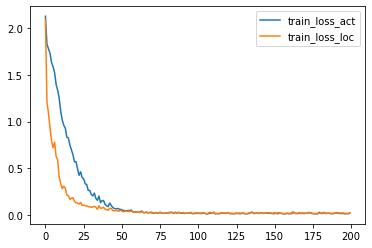

In [30]:
# train loss act vs loc
train_loss_act_df = pd.DataFrame(train_loss_act)
train_loss_act_df = train_loss_act_df.rename(columns={0:'train_loss_act'})
train_loss_loc_df = pd.DataFrame(train_loss_loc)
train_loss_loc_df = train_loss_loc_df.rename(columns={0:'train_loss_loc'})
pd.concat([train_loss_act_df,train_loss_loc_df], axis=1).plot()

<AxesSubplot:>

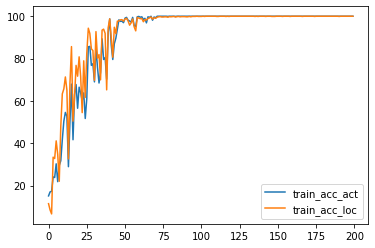

In [32]:
# train acc act vs loc
train_acc_act_df = pd.DataFrame(train_acc_act)
train_acc_act_df = train_acc_act_df.rename(columns={0:'train_acc_act'})
train_acc_loc_df = pd.DataFrame(train_acc_loc)
train_acc_loc_df = train_acc_loc_df.rename(columns={0:'train_acc_loc'})
pd.concat([train_acc_act_df,train_acc_loc_df], axis=1).plot()

<AxesSubplot:>

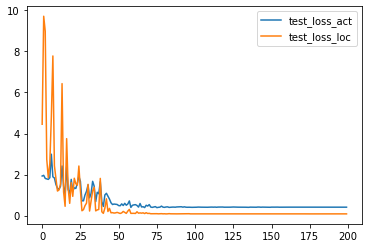

In [33]:
# test loss act vs loc
test_loss_act_df = pd.DataFrame(test_loss_act)
test_loss_act_df = test_loss_act_df.rename(columns={0:'test_loss_act'})
test_loss_loc_df = pd.DataFrame(test_loss_loc)
test_loss_loc_df = test_loss_loc_df.rename(columns={0:'test_loss_loc'})
pd.concat([test_loss_act_df,test_loss_loc_df], axis=1).plot()

<AxesSubplot:>

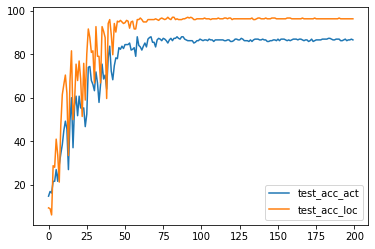

In [34]:
# test acc act vs loc
test_acc_act_df = pd.DataFrame(test_acc_act)
test_acc_act_df = test_acc_act_df.rename(columns={0:'test_acc_act'})
test_acc_loc_df = pd.DataFrame(test_acc_loc)
test_acc_loc_df = test_acc_loc_df.rename(columns={0:'test_acc_loc'})
pd.concat([test_acc_act_df,test_acc_loc_df], axis=1).plot()

In [37]:
resnet_df = pd.concat([train_loss_act_df,train_loss_loc_df,train_acc_act_df,train_acc_loc_df,test_loss_act_df,test_loss_loc_df,test_acc_act_df,test_acc_loc_df], axis=1)

In [40]:
resnet_df

,train_loss_act,train_loss_loc,train_acc_act,train_acc_loc,test_loss_act,test_loss_loc,test_acc_act,test_acc_loc
0,2.126259,2.085431,15.143369,11.469534,1.930132,4.452474,14.748201,9.352518
1,1.827012,1.213976,17.025090,8.512545,1.963923,9.714548,16.906475,8.992806
2,1.779934,1.089012,17.293907,6.630824,1.813256,8.983840,16.187050,6.115108
3,1.730595,0.935993,24.103943,33.422939,1.788092,2.736783,21.582734,28.776978
4,1.633120,0.794818,23.835125,32.795699,1.766995,1.849026,21.582734,28.057554
...,...,...,...,...,...,...,...,...
195,0.019597,0.026323,100.000000,100.000000,0.409568,0.085041,86.330935,96.402878
196,0.014314,0.018598,100.000000,100.000000,0.410697,0.086022,86.690647,96.402878
197,0.018769,0.020224,100.000000,100.000000,0.410346,0.086013,86.690647,96.402878
198,0.015109,0.019629,100.000000,100.000000,0.413026,0.086507,87.050360,96.402878


In [42]:
resnet_df.to_csv('resnet_epoch.csv')